In [3]:
import warnings
warnings.filterwarnings("ignore")


import numpy as np
from concurrent.futures import ProcessPoolExecutor
import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorly as tl

#Debugging import
import importlib
var = 'TensorDecisionTreeRegressorP' #the published version of code
package = importlib.import_module(var)
for name, value in package.__dict__.items():
    if not name.startswith("__"):
        globals()[name] = value

from TensorDecisionTreeRegressorP import *

import os
import nibabel as nib
import numpy as np
import matplotlib as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# File path to the CSV file
csv_file = '/Users/zc56/Documents/CommenDesktop/RICE/MyProject/Bayes_Tensor_Tree/3D-images/ADNIData.csv'
#csv_file = '/home/zc56/Bayes_Tensor_Tree/3D-images/ADNIData.csv'
# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file)

# Extract the 'ADAS11' column as the y variable
y_variable = df['RAVLT_forgetting'].values  # Convert to NumPy array if needed

# Print the shape and first few values of the y variable
print(f"y variable shape: {y_variable.shape}")
print(f"First 5 values of y variable: {y_variable[:5]}")



directory = '/Users/zc56/Documents/CommenDesktop/RICE/MyProject/Bayes_Tensor_Tree/3D-images/3D-Images/bl'
#directory = '/home/zc56/Bayes_Tensor_Tree/3D-images/3D-Images/bl'
# Initialize a list to hold 3D images
# Initialize a list to hold 3D images
image_list = []

# Loop over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.nii.gz'):
        file_path = os.path.join(directory, filename)
        
        # Load the NIfTI file
        img = nib.load(file_path)
        
        # Get the data as a NumPy array
        data = img.get_fdata()
        
        # Append the 3D image data to the list
        image_list.append(data)
        
        # Print the filename and data shape
        #print(f"Loaded {filename}, shape: {data.shape}")

# Stack the 3D images along a new axis to create a 4D tensor
if image_list:
    image_tensor = np.stack(image_list, axis=0)
    #print(f"Stacked 4D tensor shape: {image_tensor.shape}")
else:
    print("No images loaded.")


X_train, X_test, y_train, y_test = train_test_split(image_tensor, y_variable, test_size=0.3, random_state=42)
y_train = np.nan_to_num(y_train, nan=0.0)
# Print the shapes of the training and testing data
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Remove rows from X_train and y_train where y_train has NaN values
non_nan_train_indices = ~np.isnan(y_train)
X_train = X_train[non_nan_train_indices]
y_train = y_train[non_nan_train_indices]

# Remove rows from X_test and y_test where y_test has NaN values
non_nan_test_indices = ~np.isnan(y_test)
X_test = X_test[non_nan_test_indices]
y_test = y_test[non_nan_test_indices]

# Print the new shapes after removing NaN values
print(f"X_train_cleaned shape: {X_train.shape}")
print(f"y_train_cleaned shape: {y_train.shape}")
print(f"X_test_cleaned shape: {X_test.shape}")
print(f"y_test_cleaned shape: {y_test.shape}")


y variable shape: (818,)
First 5 values of y variable: [3. 5. 1. 4. 3.]
X_train shape: (572, 48, 48, 48)
y_train shape: (572,)
X_test shape: (246, 48, 48, 48)
y_test shape: (246,)
X_train_cleaned shape: (572, 48, 48, 48)
y_train_cleaned shape: (572,)
X_test_cleaned shape: (245, 48, 48, 48)
y_test_cleaned shape: (245,)


In [4]:
import matplotlib.pyplot as plt

def plot_tensor_slices(tensor1, tensor2, title1="Tensor 1", title2="Tensor 2", num_slices=5):
    """
    Plot corresponding slices from two 3D tensors vertically for comparison.
    Args:
    - tensor1, tensor2: The 3D tensors to compare.
    - title1, title2: Titles for the subplots.
    - num_slices: Number of slices to display.
    """
    fig, axes = plt.subplots(2 * num_slices, 1, figsize=(5, 2 * num_slices))  # Single column, double rows
    
    for i in range(num_slices):
        slice_idx = i * (tensor1.shape[2] // num_slices)  # Evenly spaced slices
        
        # Plot slice from tensor1
        axes[2 * i].imshow(tensor1[:, :, slice_idx], cmap='gray')
        axes[2 * i].set_title(f"{title1} - Slice {slice_idx}")
        axes[2 * i].axis('off')
        
        # Plot slice from tensor2
        axes[2 * i + 1].imshow(tensor2[:, :, slice_idx], cmap='gray')
        axes[2 * i + 1].set_title(f"{title2} - Slice {slice_idx}")
        axes[2 * i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

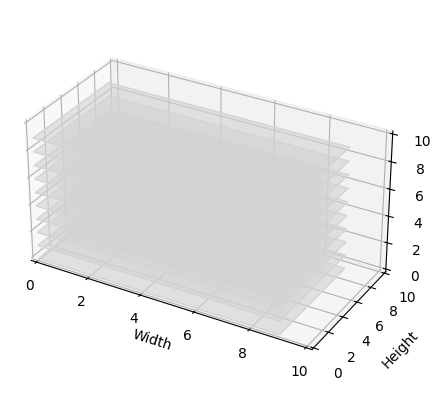

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Assume `data` is your 3D numpy array with shape (depth, height, width)
def plot_3d_slices(data, slice_type='horizontal'):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([2,1,1])  # Optional: Adjust aspect ratio

    # Define the spacing between slices
    spacing = 1

    if slice_type == 'horizontal':  # Stacks of horizontal slices
        for i in range(data.shape[0]):
            # Define the vertices of each slice as a rectangle in 3D
            z = i * spacing
            x, y = np.meshgrid(range(data.shape[2]), range(data.shape[1]))
            verts = [[(x[0, 0], y[0, 0], z), (x[0, -1], y[0, -1], z),
                      (x[-1, -1], y[-1, -1], z), (x[-1, 0], y[-1, 0], z)]]
            ax.add_collection3d(Poly3DCollection(verts, color='lightgrey', alpha=0.6))

    elif slice_type == 'vertical_x':  # Stacks of vertical slices along x-axis
        for i in range(data.shape[2]):
            x = i * spacing
            z, y = np.meshgrid(range(data.shape[0]), range(data.shape[1]))
            verts = [[(x, y[0, 0], z[0, 0]), (x, y[0, -1], z[0, -1]),
                      (x, y[-1, -1], z[-1, -1]), (x, y[-1, 0], z[-1, 0])]]
            ax.add_collection3d(Poly3DCollection(verts, color='lightgrey', alpha=0.6))

    elif slice_type == 'vertical_y':  # Stacks of vertical slices along y-axis
        for i in range(data.shape[1]):
            y = i * spacing
            z, x = np.meshgrid(range(data.shape[0]), range(data.shape[2]))
            verts = [[(x[0, 0], y, z[0, 0]), (x[0, -1], y, z[0, -1]),
                      (x[-1, -1], y, z[-1, -1]), (x[-1, 0], y, z[-1, 0])]]
            ax.add_collection3d(Poly3DCollection(verts, color='lightgrey', alpha=0.6))

    # Set plot limits and labels
    ax.set_xlim([0, data.shape[2]])
    ax.set_ylim([0, data.shape[1]])
    ax.set_zlim([0, data.shape[0] * spacing])
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    ax.set_zlabel('Depth')

    plt.show()

# Example usage with a random 3D array
data = np.random.rand(10, 10, 10)  # Replace with your 3D array
plot_3d_slices(data, slice_type='horizontal')  # Choose slice type: 'horizontal', 'vertical_x', or 'vertical_y'

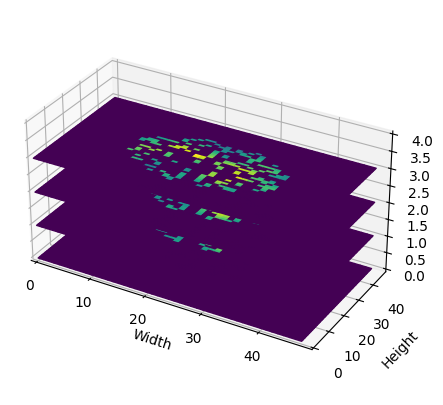

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_slices_with_values(data, slice_type='horizontal', cmap='viridis'):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([2, 1, 1])  # Optional: Adjust aspect ratio

    # Define the spacing between slices
    spacing = 1

    if slice_type == 'horizontal':  # Stacks of horizontal slices
        for i in range(data.shape[0]):
            z = i * spacing
            X, Y = np.meshgrid(range(data.shape[2]), range(data.shape[1]))
            Z = np.full_like(X, z)  # Create a 2D array filled with `z` for the depth
            ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=plt.cm.viridis(data[i] / data.max()), shade=False)
            ax.text(data.shape[2] / 2, data.shape[1] / 2, z, f'Slice {i+1}', ha='center', color='white')

    elif slice_type == 'vertical_x':  # Stacks of vertical slices along x-axis
        for i in range(data.shape[2]):
            x = i * spacing
            Y, Z = np.meshgrid(range(data.shape[1]), range(data.shape[0]))
            X = np.full_like(Y, x)  # Create a 2D array filled with `x` for the depth
            ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=plt.cm.viridis(data[:, :, i] / data.max()), shade=False)
            ax.text(x, data.shape[1] / 2, data.shape[0] / 2, f'Slice {i+1}', ha='center', color='white')

    elif slice_type == 'vertical_y':  # Stacks of vertical slices along y-axis
        for i in range(data.shape[1]):
            y = i * spacing
            X, Z = np.meshgrid(range(data.shape[2]), range(data.shape[0]))
            Y = np.full_like(X, y)  # Create a 2D array filled with `y` for the depth
            ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=plt.cm.viridis(data[:, i, :] / data.max()), shade=False)
            ax.text(data.shape[2] / 2, y, data.shape[0] / 2, f'Slice {i+1}', ha='center', color='white')

    # Set plot limits and labels
    ax.set_xlim([0, data.shape[2]])
    ax.set_ylim([0, data.shape[1]])
    ax.set_zlim([0, data.shape[0] * spacing])
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    ax.set_zlabel('Depth')

    plt.show()

# Example usage with a random 3D array
data = np.random.rand(10, 10, 10)  # Replace with your 3D array
plot_3d_slices_with_values(image_tensor[1][[2,3,4,5]], slice_type='horizontal', cmap='viridis')  # Choose slice type: 'horizontal', 'vertical_x', or 'vertical_y'

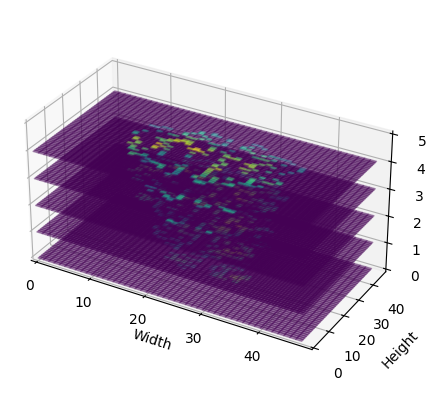

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

def plot_3d_slices_with_values(data, slice_type='horizontal', cmap='viridis', alpha=0.3):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([2, 1, 1])  # Optional: Adjust aspect ratio

    # Create a colormap with alpha for transparency
    base_cmap = plt.cm.get_cmap(cmap)
    transparent_cmap = base_cmap(np.arange(base_cmap.N))
    transparent_cmap[:, -1] = alpha  # Set the alpha channel
    transparent_cmap = ListedColormap(transparent_cmap)

    # Define the spacing between slices
    spacing = 1

    if slice_type == 'horizontal':  # Stacks of horizontal slices
        for i in range(data.shape[0]):
            z = i * spacing
            X, Y = np.meshgrid(range(data.shape[2]), range(data.shape[1]))
            Z = np.full_like(X, z)  # Create a 2D array filled with `z` for the depth
            ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=transparent_cmap(data[i] / data.max()), shade=False)

    elif slice_type == 'vertical_x':  # Stacks of vertical slices along x-axis
        for i in range(data.shape[2]):
            x = i * spacing
            Y, Z = np.meshgrid(range(data.shape[1]), range(data.shape[0]))
            X = np.full_like(Y, x)  # Create a 2D array filled with `x` for the depth
            ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=transparent_cmap(data[:, :, i] / data.max()), shade=False)

    elif slice_type == 'vertical_y':  # Stacks of vertical slices along y-axis
        for i in range(data.shape[1]):
            y = i * spacing
            X, Z = np.meshgrid(range(data.shape[2]), range(data.shape[0]))
            Y = np.full_like(X, y)  # Create a 2D array filled with `y` for the depth
            ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=transparent_cmap(data[:, i, :] / data.max()), shade=False)

    # Set plot limits and labels
    ax.set_xlim([0, data.shape[2]])
    ax.set_ylim([0, data.shape[1]])
    ax.set_zlim([0, data.shape[0] * spacing])
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    ax.set_zlabel('Depth')

    plt.show()

# Example usage with a random 3D array
data = np.random.rand(10, 50, 50)  # Replace with your 3D array
plot_3d_slices_with_values(image_tensor[1][[2,3,4,5,6]], slice_type='horizontal', cmap='viridis', alpha=0.4)  # Adjust alpha for more transparency

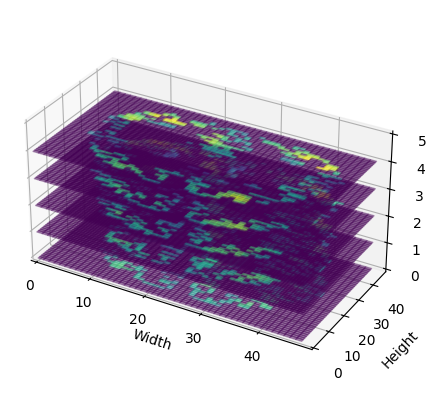

In [37]:
plot_3d_slices_with_values(image_tensor[1][[12,13,14,15,16]], slice_type='horizontal', cmap='viridis', alpha=0.4)

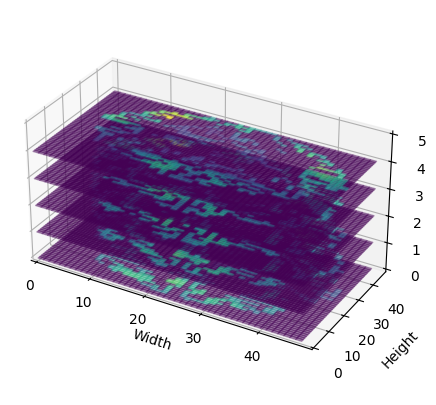

In [38]:
plot_3d_slices_with_values(image_tensor[1][[22,23,24,25,26]], slice_type='horizontal', cmap='viridis', alpha=0.4)

In [40]:
import pandas as pd

# Define the multi-index for the header
header = pd.MultiIndex.from_tuples([
    ('BT-SVM', 'Mis. C.'), ('BT-SVM', 'F1-score'),
    ('BT-LR', 'Mis. C.'), ('BT-LR', 'F1-score'),
    ('LR-lasso', 'Mis. C.'), ('LR-lasso', 'F1-score'),
    ('L1norm-SVM', 'Mis. C.'), ('L1norm-SVM', 'F1-score')
])

# Define data
data = [
    [0.288, 0.764, 0.317, 0.728, 0.337, 0.750, 0.422, 0.636],
    [0.280, 0.762, 0.292, 0.748, 0.361, 0.729, 0.398, 0.654],
    [0.296, 0.752, 0.300, 0.756, 0.357, 0.750, 0.447, 0.595],
    [0.284, 0.779, 0.333, 0.723, 0.361, 0.729, 0.504, 0.550],
    [0.256, 0.789, 0.325, 0.733, 0.373, 0.657, 0.390, 0.684],
    [0.280, 0.771, 0.325, 0.720, 0.398, 0.611, 0.447, 0.618],
    [0.256, 0.801, 0.345, 0.719, 0.369, 0.674, 0.455, 0.591]
]

# Define row labels
rows = ['slice 19', 'slice 20', 'slice 21', 'slice 22', 'slice 23', 'slice 24', 'slice 25']

# Create the DataFrame
df = pd.DataFrame(data, index=rows, columns=header)

# Display the DataFrame as a styled table
styled_df = df.style.set_caption("Female vs. Male").set_table_styles([
    {'selector': 'caption', 'props': 'caption-side: bottom; font-weight: bold; text-align: center;'},
    {'selector': 'th', 'props': [('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]},
    {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]}
]).hide(axis="index")

styled_df

In [41]:
with open("table.tex", "w") as f:
    f.write(df.to_latex(multicolumn=True, multirow=True, caption="Female vs. Male"))

In [42]:
import pandas as pd

# Define the multi-index for the header
header = pd.MultiIndex.from_tuples([
    ('BT-SVM', 'Mis. C.'), ('BT-SVM', 'F1-score'),
    ('BT-LR', 'Mis. C.'), ('BT-LR', 'F1-score'),
    ('LR-lasso', 'Mis. C.'), ('LR-lasso', 'F1-score'),
    ('L1norm-SVM', 'Mis. C.'), ('L1norm-SVM', 'F1-score')
])

# Define data
data = [
    [0.288, 0.764, 0.317, 0.728, 0.337, 0.750, 0.422, 0.636],
    [0.280, 0.762, 0.292, 0.748, 0.361, 0.729, 0.398, 0.654],
    [0.296, 0.752, 0.300, 0.756, 0.357, 0.750, 0.447, 0.595],
    [0.284, 0.779, 0.333, 0.723, 0.361, 0.729, 0.504, 0.550],
    [0.256, 0.789, 0.325, 0.733, 0.373, 0.657, 0.390, 0.684],
    [0.280, 0.771, 0.325, 0.720, 0.398, 0.611, 0.447, 0.618],
    [0.256, 0.801, 0.345, 0.719, 0.369, 0.674, 0.455, 0.591]
]

# Define row labels
rows = ['slice 19', 'slice 20', 'slice 21', 'slice 22', 'slice 23', 'slice 24', 'slice 25']

# Create the DataFrame
df = pd.DataFrame(data, index=rows, columns=header)

# Generate LaTeX code for the table
latex_code = df.to_latex(multicolumn=True, multirow=True, caption="Female vs. Male", label="table:female_vs_male", column_format="l" + "cc" * 4)

# Output the LaTeX code
print(latex_code)

\begin{table}
\caption{Female vs. Male}
\label{table:female_vs_male}
\begin{tabular}{lcccccccc}
\toprule
 & \multicolumn{2}{r}{BT-SVM} & \multicolumn{2}{r}{BT-LR} & \multicolumn{2}{r}{LR-lasso} & \multicolumn{2}{r}{L1norm-SVM} \\
 & Mis. C. & F1-score & Mis. C. & F1-score & Mis. C. & F1-score & Mis. C. & F1-score \\
\midrule
slice 19 & 0.288000 & 0.764000 & 0.317000 & 0.728000 & 0.337000 & 0.750000 & 0.422000 & 0.636000 \\
slice 20 & 0.280000 & 0.762000 & 0.292000 & 0.748000 & 0.361000 & 0.729000 & 0.398000 & 0.654000 \\
slice 21 & 0.296000 & 0.752000 & 0.300000 & 0.756000 & 0.357000 & 0.750000 & 0.447000 & 0.595000 \\
slice 22 & 0.284000 & 0.779000 & 0.333000 & 0.723000 & 0.361000 & 0.729000 & 0.504000 & 0.550000 \\
slice 23 & 0.256000 & 0.789000 & 0.325000 & 0.733000 & 0.373000 & 0.657000 & 0.390000 & 0.684000 \\
slice 24 & 0.280000 & 0.771000 & 0.325000 & 0.720000 & 0.398000 & 0.611000 & 0.447000 & 0.618000 \\
slice 25 & 0.256000 & 0.801000 & 0.345000 & 0.719000 & 0.369000 & 0.67400